In [1]:
# libraries
import os
import sys
import json
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../extra_files'))
import helper as hp
from imageio import imwrite, imread
from skimage.transform import resize

In [2]:
# File paths
data_path = '/home/aldo/Documents/data-cic/'
preprocess_path = data_path + 'preprocess_data'

## Training SSD300 trained with mobilenet backbone trained

In [3]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from light_models.keras_ssd300_shufflenetv2_ssdlayers_light_relu6_se_no_shuffle import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files.f1_callback import F1_callback as f1_call

Using TensorFlow backend.
/home/aldo/Documents/ssd/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


### Parameters (original SSD300 architecture)

In [4]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [1., 1., 1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

## Create new model with SSD weights

In [5]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           input_stddev_normalization[0][0] 
__________________________________________________________________________________________________
model_1 (M

## Data generator for the training

In [7]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = data_path + 'PASCAL'
#images_dir = data_path + 'COCO'

# Ground truth
#train_labels_filename = preprocess_path + '/PASCAL_train.csv'
train_labels_filename = preprocess_path + '/PASCAL_train_val.csv'
val_labels_filename   = preprocess_path + '/PASCAL_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(#images_dir=images_dir,
                      data_path + 'PASCAL',
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|██████████| 1025/1025 [00:04<00:00, 244.35it/s]
Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


In [8]:
# 3: Set the batch size.
batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.
# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.
# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv13_mbox_conf').output_shape[1:3],
                   model.get_layer('conv18_mbox_conf').output_shape[1:3],
                   model.get_layer('conv19_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv20_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv21_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv22_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


## Remaining training parameters

In [9]:
# Define a learning rate schedule.
def lr_schedule(epoch):
    if epoch < 50:
        return 0.0001
    else:
        return 0.00001

In [12]:
lr_list = [0.01, 0.001, 0.0001, 0.00001]

for lr in lr_list:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH LEARNING RATE:', lr)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=lr)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.load_weights('/home/aldo/Documents/weights/light_models/PASCAL/shufflenet_v2_ssdlayers_no_shuffle_light_relu6_se_coco_factor_1.5.h5', by_name=True)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Downloads/shufflenetv2_coco_pascal/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'model_' + str(lr) + '.csv',
                           separator=',',
                           append=True)


    f1_callback = f1_call(0.20, 
                           0.45, 
                           200, 
                           normalize_coords, 
                           img_height, 
                           img_width, 
                           (1, 2268, 14),
                           main_path + 'f1_' + str(lr) + '.csv',
                           main_path + 'model.h5',
                           label_csv='/home/aldo/Documents/data-cic/preprocess_data/PASCAL_val.csv',
                           path_img='/home/aldo/Documents/data-cic/PASCAL',
                           verborse=True)


    callbacks = [csv_logger,
                 f1_callback]
    
    initial_epoch   = 0
    final_epoch     = 100
    steps_per_epoch = 200

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  validation_data=val_generator,
                                  validation_steps=ceil(val_dataset_size/batch_size),
                                  initial_epoch=initial_epoch)

TRAINING MODEL WITH LEARNING RATE: 0.01
Epoch 1/100
200/200 [==============================] - 127s 634ms/step - loss: 4.6138 - val_loss: 4.9903
Number of images: 1025
Presicion: 0.0301
Recall: 0.4525
F1 score: 0.0564
F1 score: 0.0563950115200371
Improve F1 score from -inf to 0.0563950115200371
Epoch 2/100
200/200 [==============================] - 110s 552ms/step - loss: 4.4967 - val_loss: 8.0698
Number of images: 1025
Presicion: 0.0533
Recall: 0.4835
F1 score: 0.096
F1 score: 0.09595759482857541
Improve F1 score from 0.0563950115200371 to 0.09595759482857541
Epoch 3/100
200/200 [==============================] - 111s 555ms/step - loss: 4.3875 - val_loss: 4.6376
Number of images: 1025
Presicion: 0.0449
Recall: 0.5102
F1 score: 0.0825
F1 score: 0.08251050834027217
Epoch 4/100
200/200 [==============================] - 107s 533ms/step - loss: 4.2531 - val_loss: 4.4847
Number of images: 1025
Presicion: 0.0823
Recall: 0.4542
F1 score: 0.1394
F1 score: 0.1393572016633071
Improve F1 score f

200/200 [==============================] - 110s 548ms/step - loss: 3.8676 - val_loss: 34.4173
Number of images: 1025
Presicion: 0.132
Recall: 0.2063
F1 score: 0.161
F1 score: 0.16099226293778637
Epoch 39/100
200/200 [==============================] - 109s 545ms/step - loss: 3.8743 - val_loss: 4.2480
Number of images: 1025
Presicion: 0.2714
Recall: 0.3909
F1 score: 0.3204
F1 score: 0.32036554396055
Epoch 40/100
200/200 [==============================] - 109s 543ms/step - loss: 3.8869 - val_loss: 4.3416
Number of images: 1025
Presicion: 0.4072
Recall: 0.2799
F1 score: 0.3317
F1 score: 0.33172915791209556
Epoch 41/100
200/200 [==============================] - 109s 546ms/step - loss: 3.8840 - val_loss: 4.0791
Number of images: 1025
Presicion: 0.3275
Recall: 0.416
F1 score: 0.3664
F1 score: 0.3664436985003766
Improve F1 score from 0.3636495526420768 to 0.3664436985003766
Epoch 42/100
200/200 [==============================] - 109s 545ms/step - loss: 3.8753 - val_loss: 4.0847
Number of imag

200/200 [==============================] - 105s 527ms/step - loss: 3.6997 - val_loss: 3.8244
Number of images: 1025
Presicion: 0.4087
Recall: 0.4132
F1 score: 0.4109
F1 score: 0.41094469746901713
Epoch 77/100
200/200 [==============================] - 105s 526ms/step - loss: 3.6568 - val_loss: 4.1498
Number of images: 1025
Presicion: 0.4064
Recall: 0.2877
F1 score: 0.3369
F1 score: 0.33693865434103526
Epoch 78/100
200/200 [==============================] - 106s 531ms/step - loss: 3.7312 - val_loss: 3.7684
Number of images: 1025
Presicion: 0.4986
Recall: 0.3682
F1 score: 0.4236
F1 score: 0.42358842282340836
Epoch 79/100
200/200 [==============================] - 105s 526ms/step - loss: 3.6763 - val_loss: 4.1732
Number of images: 1025
Presicion: 0.4047
Recall: 0.3725
F1 score: 0.3879
F1 score: 0.38793016514849227
Epoch 80/100
200/200 [==============================] - 105s 527ms/step - loss: 3.6157 - val_loss: 3.8321
Number of images: 1025
Presicion: 0.4196
Recall: 0.3952
F1 score: 0.407

Epoch 13/100
200/200 [==============================] - 107s 534ms/step - loss: 3.0169 - val_loss: 3.0322
Number of images: 1025
Presicion: 0.606
Recall: 0.4992
F1 score: 0.5475
F1 score: 0.54745080379973
Epoch 14/100
200/200 [==============================] - 104s 522ms/step - loss: 3.0044 - val_loss: 3.0207
Number of images: 1025
Presicion: 0.6267
Recall: 0.4908
F1 score: 0.5505
F1 score: 0.550490906554278
Improve F1 score from 0.5475143481556608 to 0.550490906554278
Epoch 15/100
200/200 [==============================] - 104s 522ms/step - loss: 3.0060 - val_loss: 3.0990
Number of images: 1025
Presicion: 0.6203
Recall: 0.478
F1 score: 0.5399
F1 score: 0.5399360918496076
Epoch 16/100
200/200 [==============================] - 105s 527ms/step - loss: 3.0237 - val_loss: 3.1030
Number of images: 1025
Presicion: 0.6003
Recall: 0.4827
F1 score: 0.5351
F1 score: 0.5351223067752985
Epoch 17/100
200/200 [==============================] - 106s 529ms/step - loss: 3.0366 - val_loss: 3.0429
Numbe

200/200 [==============================] - 106s 532ms/step - loss: 2.9265 - val_loss: 3.0289
Number of images: 1025
Presicion: 0.649
Recall: 0.4672
F1 score: 0.5433
F1 score: 0.5432891653563785
Epoch 53/100
200/200 [==============================] - 105s 525ms/step - loss: 2.9273 - val_loss: 3.0619
Number of images: 1025
Presicion: 0.6299
Recall: 0.4669
F1 score: 0.5363
F1 score: 0.5362912568022992
Epoch 54/100
200/200 [==============================] - 105s 525ms/step - loss: 2.9447 - val_loss: 3.0538
Number of images: 1025
Presicion: 0.623
Recall: 0.4789
F1 score: 0.5416
F1 score: 0.5415619161700309
Epoch 55/100
200/200 [==============================] - 105s 527ms/step - loss: 2.9686 - val_loss: 3.0678
Number of images: 1025
Presicion: 0.6003
Recall: 0.4977
F1 score: 0.5442
F1 score: 0.5442136273118606
Epoch 56/100
200/200 [==============================] - 106s 530ms/step - loss: 2.9177 - val_loss: 3.0813
Number of images: 1025
Presicion: 0.6384
Recall: 0.475
F1 score: 0.5447
F1 sc

Epoch 28/100
200/200 [==============================] - 106s 529ms/step - loss: 2.9376 - val_loss: 2.8888
Number of images: 1025
Presicion: 0.638
Recall: 0.5112
F1 score: 0.5676
F1 score: 0.567603868180203
Epoch 29/100
200/200 [==============================] - 106s 529ms/step - loss: 2.9677 - val_loss: 2.8906
Number of images: 1025
Presicion: 0.6431
Recall: 0.5073
F1 score: 0.5672
F1 score: 0.5671739091298543
Epoch 30/100
200/200 [==============================] - 105s 525ms/step - loss: 2.9607 - val_loss: 2.8892
Number of images: 1025
Presicion: 0.6412
Recall: 0.509
F1 score: 0.5675
F1 score: 0.567491526608593
Epoch 31/100
200/200 [==============================] - 113s 566ms/step - loss: 2.9657 - val_loss: 2.9080
Number of images: 1025
Presicion: 0.6333
Recall: 0.5082
F1 score: 0.5639
F1 score: 0.5638863622621464
Epoch 32/100
200/200 [==============================] - 118s 589ms/step - loss: 2.9679 - val_loss: 2.8819
Number of images: 1025
Presicion: 0.6376
Recall: 0.5124
F1 score: 

Epoch 4/100
200/200 [==============================] - 106s 530ms/step - loss: 3.0578 - val_loss: 2.9404
Number of images: 1025
Presicion: 0.5878
Recall: 0.5218
F1 score: 0.5528
F1 score: 0.5528197622203548
Improve F1 score from 0.5523040539234076 to 0.5528197622203548
Epoch 5/100
200/200 [==============================] - 106s 530ms/step - loss: 3.0514 - val_loss: 2.9383
Number of images: 1025
Presicion: 0.5947
Recall: 0.5204
F1 score: 0.5551
F1 score: 0.5550875467082754
Improve F1 score from 0.5528197622203548 to 0.5550875467082754
Epoch 6/100
200/200 [==============================] - 106s 532ms/step - loss: 3.0401 - val_loss: 2.9351
Number of images: 1025
Presicion: 0.5986
Recall: 0.5194
F1 score: 0.5562
F1 score: 0.5561741866715445
Improve F1 score from 0.5550875467082754 to 0.5561741866715445
Epoch 7/100
200/200 [==============================] - 106s 531ms/step - loss: 3.0475 - val_loss: 2.9343
Number of images: 1025
Presicion: 0.6025
Recall: 0.5185
F1 score: 0.5574
F1 score: 0.

200/200 [==============================] - 105s 526ms/step - loss: 2.9712 - val_loss: 2.9125
Number of images: 1025
Presicion: 0.6258
Recall: 0.5128
F1 score: 0.5637
F1 score: 0.5637053693057559
Epoch 40/100
200/200 [==============================] - 106s 529ms/step - loss: 2.9837 - val_loss: 2.9134
Number of images: 1025
Presicion: 0.6263
Recall: 0.5138
F1 score: 0.5645
F1 score: 0.5645219151552299
Epoch 41/100
200/200 [==============================] - 105s 525ms/step - loss: 2.9795 - val_loss: 2.9126
Number of images: 1025
Presicion: 0.6264
Recall: 0.5139
F1 score: 0.5646
F1 score: 0.5646162113577899
Epoch 42/100
200/200 [==============================] - 106s 528ms/step - loss: 3.0339 - val_loss: 2.9178
Number of images: 1025
Presicion: 0.6293
Recall: 0.5122
F1 score: 0.5647
F1 score: 0.564727321843387
Epoch 43/100
200/200 [==============================] - 106s 532ms/step - loss: 2.9844 - val_loss: 2.9132
Number of images: 1025
Presicion: 0.6271
Recall: 0.5132
F1 score: 0.5645
F1 

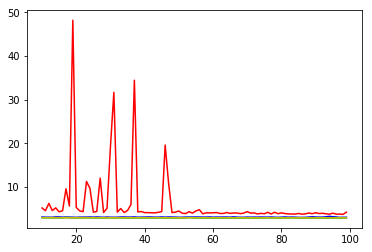

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
mob_01 = pd.read_csv(main_path + 'model_0.01.csv')
mob_001 = pd.read_csv(main_path + 'model_0.001.csv')
mob_0001 = pd.read_csv(main_path + 'model_0.0001.csv')
mob_00001 = pd.read_csv(main_path + 'model_1e-05.csv')


fig, ax = plt.subplots()
ax.plot(mob_01['epoch'][10:], mob_01['val_loss'][10:], color='r')
ax.plot(mob_001['epoch'][10:], mob_001['val_loss'][10:], color='b')
ax.plot(mob_0001['epoch'][10:], mob_0001['val_loss'][10:], color='g')
ax.plot(mob_00001['epoch'][10:], mob_00001['val_loss'][10:], color='y')

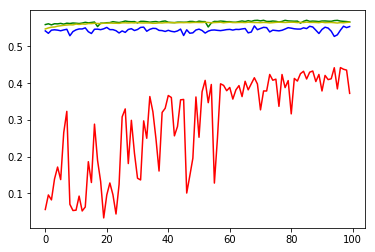

In [16]:
mob_01_f1 = pd.read_csv(main_path + 'f1_0.01.csv')
mob_001_f1 = pd.read_csv(main_path + 'f1_0.001.csv')
mob_0001_f1 = pd.read_csv(main_path + 'f1_0.0001.csv')
mob_00001_f1 = pd.read_csv(main_path + 'f1_1e-05.csv')


fig, ax = plt.subplots()
ax.plot(mob_01_f1['epoch'], mob_01_f1['f1 score'], color='r')
ax.plot(mob_001_f1['epoch'], mob_001_f1['f1 score'], color='b')
ax.plot(mob_0001_f1['epoch'], mob_0001_f1['f1 score'], color='g')
ax.plot(mob_00001_f1['epoch'], mob_00001_f1['f1 score'], color='y')

In [10]:
scale_factors = [1.5]

for factor in scale_factors:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH FACTOR:', factor)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=factor,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=0.001)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.load_weights('/home/aldo/Documents/weights/light_models/PASCAL/shufflenet_v2_ssdlayers_no_shuffle_light_relu6_se_coco_factor_1.5.h5', by_name=True)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Documents/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'data-cic/history/light_models/PASCAL/shufflenet_v2_ssdlayers_no_shuffle_light_relu6_se_coco_pascal_factor_' + 
                           str(factor) + '.csv',
                           separator=',',
                           append=True)

    learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule, verbose=1)


    callbacks = [csv_logger,
                 learning_rate_scheduler]
    
    initial_epoch   = 0
    final_epoch     = 60
    steps_per_epoch = 1000

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  initial_epoch=initial_epoch)
    
    model.save(main_path + 'weights/light_models/PASCAL/shufflenet_v2_ssdlayers_no_shuffle_light_relu6_se_coco_pascal_factor_' + str(factor) + '.h5')

TRAINING MODEL WITH FACTOR: 1.5
Epoch 1/60

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 572s 572ms/step - loss: 3.0258
Epoch 2/60

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 561s 561ms/step - loss: 3.0005
Epoch 3/60

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 561s 561ms/step - loss: 3.0037
Epoch 4/60

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 568s 568ms/step - loss: 2.9878
Epoch 5/60

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 569s 569ms/step - loss: 2.9871
Epoch 6/60

Epoch 00006: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 547s 547ms/step - loss: 2.9673
Epoch 7/60

Epoch 00007: Learnin

1000/1000 [==============================] - 540s 540ms/step - loss: 2.8415
Epoch 54/60

Epoch 00054: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 540s 540ms/step - loss: 2.8511
Epoch 55/60

Epoch 00055: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 541s 541ms/step - loss: 2.8352
Epoch 56/60

Epoch 00056: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 543s 543ms/step - loss: 2.8508
Epoch 57/60

Epoch 00057: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 541s 541ms/step - loss: 2.8584
Epoch 58/60

Epoch 00058: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 542s 542ms/step - loss: 2.8482
Epoch 59/60

Epoch 00059: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 544s 544ms/step - l